# PubChem validation
This notebook demonstrates a new (?) idea in LBVS validation - pinging the pubchem server for assays for a given compound / target pair, and assessing the Outcome field. 

The main difficulty/novelty here is automating the approach while ensuring it gets the CORRECT assay. This is because many targets have different names, and there is no standard format for assay descriptions *or* outcomes.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# Make some structure-predictions with label correlations:



In [2]:
#all labels:
interaction_matrix = sparse.load_npz('../0_data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../0_data/pchembl_chemicals.csv')
targets_df= pd.read_csv('../0_data/subset_targets.csv')

In [3]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  0%|          | 280/85681 [00:00<00:30, 2790.01it/s]

y_in shape is: (337951, 243)


100%|██████████| 337951/337951 [00:49<00:00, 6856.65it/s]


In [4]:
train, test, fps = utils.load_time_split(year=2030, 
                                         return_fingerprints=True) #set a year after now to get ALL records

probability_arr = probability_matrix.toarray()

In [5]:
##sort the predictions in order of probability, highest first. 

arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.99991256
Should be a low number >= 0:
0.0
Sorted array indices:


array([[328242,    138],
       [ 68104,    138],
       [315225,     72],
       ...,
       [132327,     26],
       [132327,     28],
       [337950,    242]])

In [6]:
#sanity check - make sure the ligand IDX, smiles, and target IDX and target names line up:

for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets_df['pref_name'].iloc[pair[1]]
    tid = targets_df[targets_df['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)

C[C@@H](Oc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL601719 C[C@@H](Oc1cc(cnc1N)c2cnn(c2)C3CCNCC3)c4c(Cl)ccc(F)c4Cl
Nc1ncnc2sc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1998585 Nc1ncnc2scc(c3ccc(NC(=O)Nc4cc(ccc4F)C(F)(F)F)cc3)c12
CCN(CC)CCN... Serine/threonine-protein kinase PIM1 	 Serine/threonine-protein kinase PIM1
CHEMBL535 CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C\2/C(=O)Nc3ccc(F)cc23)c1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
Cn1cc(cn1)... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1988717 Cn1cc(cn1)c2cnn3c(N)c(cnc23)c4ccc(NC(=O)Nc5cccc(c5)C(F)(F)F)cc4
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc

# PubChem-pinging 

This became much cleaner when wrapped in a class. The below uses a class to perform a number of functions:

- save/load checkpoints - i.e. if something breaks, or you want to come back to this later after shutting the laptop, you can save all the data and load it afterwards to pick back up
- ping `pubchempy` for compound ID (CID) numbers.
- ping `chembl_webresource_client` for target synonyms
- ping pubchem REST API for assays associated with a CID
- records all of this stuff in dicts to be saved as JSON so I can parse it later. 

In [7]:
from pubval import PubChemValidator
pcv = PubChemValidator(targets_df, interaction_matrix, fps)
#pcv.targets = {}

# How many predictions to sample, and which ones?

Ideally we want to sample a good few predictions that have high probabilities. But we also want to see how well it performs at lower probabilities. The problem is that even sampling over the highest, say, 10,000,000 predictions will be highly biased toward lower probabilities! So we try to weight the random selection to balance it out, selection an even number of high- and low-scoring predictions.

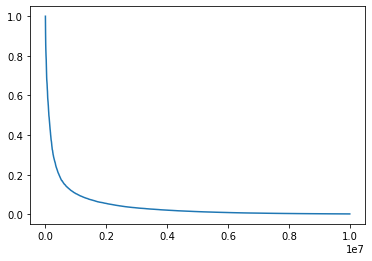

In [8]:
num = 10_000_000
probs = probability_arr[arr_sorted[:,0][:num], arr_sorted[:,1][:num]]
plt.plot(probs)

In [36]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

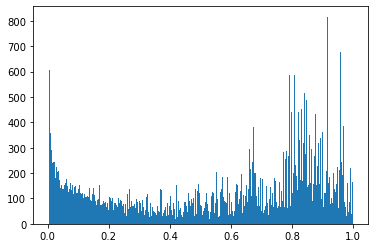

In [37]:
sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

# Do the sampling.


In [38]:
pcv.load_checkpoint()

In [39]:
##resetting predictions because I made a previous mistake in calculating nnranks
#pcv.predictions = {}

In [ ]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[97831   127]
[207869    154]
[58245    72]
[147898    127]
[67469    72]
[282938    116]
[249880     84]
[238044    104]
[282998    116]
[46165    98]
[66080   138]
[142970    127]
[83796    14]
[156621     75]
[198445    215]
[141413     64]
[187592     79]
[67289   136]
[97834    52]
[186888    233]
[73631     9]
[106889    164]
[279425    166]
[82075   165]
[66961   178]
[109954     90]
[333728    170]
[276401    138]
[298128     90]
[23364    91]
[67985   224]
[66584   157]
[334297    112]
[102333     95]
[335917     82]
[93696    36]
[277995    127]
[122315    179]
[283374    166]
[9341   81]
[117659     94]
[68364   215]
[132892     82]
[109387     29]
[332552     76]
[161643     95]
[298713    177]
[131406     52]
[43391   170]
[120961     90]
[68194    16]
[83392   149]
[294762     76]
[109666    224]
[188503    198]
[219524     84]
[126466    167]
[131398     52]
[162910     52]
[321587    127]
[1739   90]
[4534  142]
[93082   116]
[83653   127]
[142590    177]
[276858    127

[329448    121]
[93928    52]
[203557    194]
[305802    149]
[223728    170]
[295831    100]
[200142     31]
[105513     76]
[185623    149]
[98620   177]
[83463   127]
[160400     83]
[157041    162]
[133129     52]
[146813     82]
[2998  233]
[108590     14]
[26497   225]
[191445     64]
[275234    149]
[311721     82]
[98988   127]
[86029   130]
[228275    166]
[281790     82]
[167016    191]
[257870    199]
[49780   169]
[302338    103]
[225389    177]
[1338   98]
[66235   142]
[2977  122]
[110851     52]
[49953   196]
[218221    127]
[139918     90]
[227486     79]
[67934   168]
[58466   233]
[36210    90]
[49028    63]
[68287   199]
[125944    179]
[8104  169]
[66238    48]
[113187    140]
[204975    187]
[183515    166]
[194514    191]
[265043    214]
[194560    138]
[250479     72]
[52409   177]
[153682     98]
[331472    127]
[217403    166]
[135660    202]
[153857    120]
[259971    165]
[277203     32]
[40070   237]
[257274    193]
[225510     16]
[275979    154]
[133132   

[255908     91]
[217725    127]
[284128    142]
[139714     76]
[320184    138]
[36519   116]
[159244     73]
[330987     84]
[24946    86]
[109870    127]
[111030     11]
[35639   170]
[68242    11]
[234162    138]
[335665    103]
[330231    171]
[304951    166]
[110863     52]
[50259    90]
[201028    178]
[3644  214]
[310264    224]
[25988    95]
[120286    198]
[122576     86]
[62898    80]
[217908    127]
[6430  149]
[67787   142]
[158030     53]
[16090   144]
[57032   214]
[255908     76]
[67806   215]
[133137    127]
[66262   142]
[308793    214]
[328242    138]
[144011     52]
[155362     52]
[200101    204]
[256364    225]
[50209    81]
[254050     53]
[171152    149]
[316943     90]
[68287    79]
[250992    102]
[201425    187]
[330564     94]
[221618    166]
[58003   214]
[160708     52]
[68211   138]
[147590    149]
[68489    79]
[279662    166]
[33562   225]
[320656    237]
[246949    109]
[178182    161]
[17087   180]
[97834   127]
[158924    170]
[96307   167]
[143898   

[103430     52]
[10566   138]
[90436   132]
[322571    103]
[67698    29]
[7997  159]
[58250    72]
[162638    175]
[66714    29]
[21455    76]
[38062   123]
[67255   224]
[38214    95]
[188803    149]
[66849    13]
[73935    88]
[310061     52]
[187593    202]
[132702     52]
[61216   167]
[150911    125]
[329189     76]
[277245    127]
[328060    205]
[100553     36]
[171428    142]
[68571    72]
[169161    121]
[110639     31]
[262804     84]
[6040  128]
[221090    150]
[68104   131]
[282091     81]
[305038    166]
[38915   112]
[11472     6]
[336208    127]
[81171   155]
[57881   155]
[276467    166]
[40541   165]
[188496    149]
[309260     52]
[253238     86]
[184041    142]
[193544    138]
[105048     73]
[16079   155]
[327794    103]
[135611    169]
[269043    138]
[199521    194]
[275129     73]
[144026     52]
[21511   112]
[23338   160]
[165645    125]
[333326     86]
[67435    72]
[233777     72]
[163387     33]
[253684     35]
[180989    159]
[211759    228]
[260036     73

[65456   194]
[110845    127]
[331009    116]
[330984    139]
[146430     52]
[150637     31]
[118276    204]
[248499    237]
[255285    126]
[132373    127]
[28950   100]
[123266     88]
[48775   103]
[77419    88]
[66155    73]
[117281    122]
[65788    90]
[194511    138]
[218242    144]
[158157    177]
[85913   121]
[66590   194]
[66681   138]
[333230     91]
[217564     52]
[296657     48]
[34533   170]
[42838    91]
[212254    236]
[144024     52]
[301358     36]
[164342    127]
[133125     52]
[259481      8]
[270363    134]
[164261     90]
[74107   108]
[130466    170]
[67449   149]
[243633     46]
[207567    100]
[185597    149]
[324147     63]
[68059   154]
[103732     16]
[68215   142]
[79785    76]
[38212   102]
[95979   191]
[104940     36]
[61895    52]
[26011   177]
[26669    52]
[209199    136]
[109949     90]
[217060    127]
[3222  233]
[84381   149]
[328764     98]
[181 177]
[329829    177]
[300071    122]
[4774  128]
[61715   181]
[49873   177]
[160346    178]
[29611

[105984    148]
[162727    177]
[68182    29]
[110331     67]
[131577    149]
[75679    18]
[225147      8]
[57083    88]
[67575   150]
[263169     14]
[67033    48]
[109758    112]
[300182     80]
[11657    90]
[214500    205]
[337845    113]
[207689    154]
[1953  166]
[262148     11]
[324902     64]
[196050    119]
[144028     52]
[262690    138]
[151082      9]
[134431     82]
[88388    49]
[212254    196]
[330501     84]
[12 67]
[70591   177]
[326699     98]
[135871    149]
[294923    136]
[15946   154]
[66998    13]
[49412    29]
[189040    166]
[171632     68]
[194533    138]
[20462   145]
[145139     18]
[146940     90]
[174129    128]
[58248    72]
[67124    79]
[130652    191]
[322494     88]
[66040   138]
[250788    215]
[247011    214]
[162894    165]
[96028    90]
[66041   215]
[171129    142]
[162909     52]
[82032    82]
[153221    144]
[67283   138]
[305192    166]
[337079     62]
[105150     72]
[255097    127]
[276203    199]
[132569     52]
[38089    80]
[334360     

[66924    36]
[316615     80]
[133124     52]
[26715   170]
[188555    214]
[183696    100]
[82324   214]
[160376     37]
[65968   224]
[113187     73]
[118261    122]
[273226     84]
[322756    138]
[97832    52]
[200995    178]
[307648    142]
[10778    76]
[81867   103]
[255232    193]
[238353    199]
[226718    165]
[90130   149]
[159019     76]
[129414    177]
[123483    220]
[291981    170]
[115300    116]
[20944   105]
[77528   180]
[2594   62]
[67454    16]
[194506    138]
[48537    84]
[238628     76]
[223374     16]
[66689   224]
[323571    131]
[277610     98]
[280050    138]
[252116    149]
[318568    111]
[127691    138]
[43030   191]
[67993   116]
[292446     94]
[148637    100]
[99591   127]
[9988   38]
[215818     86]
[337628    127]
[262458    102]
[161396     30]
[314977    194]
[75265   138]
[280407     52]
[308605     72]
[314342     95]
[160713    127]
[152895    164]
[68912    67]
[311453     90]
[267062     36]
[45431    83]
[90601    79]
[243097     79]
[123512 

[15860    72]
[90321    84]
[222699    102]
[15443    90]
[35598    76]
[40649    15]
[155363    127]
[250744    100]
[62817   214]
[98639   177]
[295432     91]
[66201    29]
[101376    102]
[295574     64]
[221189     89]
[41902   139]
[8847  127]
[331154    127]
[302241    178]
[130841     52]
[300011     52]
[292003    127]
[282948     88]
[220213    138]
[230744    194]
[128863    127]
[67934   123]
[226757    119]
[226301    121]
[194545    138]
[2299  130]
[215665    165]
[73151   128]
[4879  123]
[138405     91]
[917 136]
[131422     86]
[66669   224]
[3680   15]
[145134    113]
[141450    116]
[121619    127]
[79605   192]
[141506     90]
[2451   63]
[1682  224]
[230025    128]
[279262     98]
[132715    127]
[62906   134]
[66017   175]
[283897    165]
[66896   199]
[318257     79]
[151995    214]
[66209    72]
[56006    84]
[226206    142]
[111481    177]
[218526     15]
[141907     84]
[105048    142]
[66596    13]
[98592   166]
[220332     46]
[62203   177]
[174168    228]


[194574    138]
[280857    161]
[99746    71]
[150824     76]
[188494    149]
[101652     52]
[67710   142]
[66596   138]
[303829     72]
[173394    215]
[124256     83]
[33942   170]
[166831    163]
[89233    38]
[185609    149]
[221103     72]
[259256     31]
[331633     98]
[44778   127]
[248647    237]
[4896   90]
[280886    172]
[329659    162]
[155362    127]
[89450   224]
[67183    76]
[198043    138]
[140613    127]
[66126    72]
[216184    182]
[144567     14]
[227593     76]
[33740    41]
[41321   128]
[11490    52]
[166529    149]
[87333    91]
[240444    102]
[78822   194]
[331888     84]
[99158    67]
[152005    142]
[75619    81]
[118076    122]
[121633     98]
[189804    237]
[83914    52]
[230305    194]
[144573     14]
[15560   177]
[267995    225]
[226302     95]
[31347   162]
[324402    139]
[66229   224]
[337044     95]
[98761   177]
[326011    127]
[215782    149]
[47695   177]
[323045    133]
[337525    162]
[48194    98]
[25231   169]
[155875    139]
[327796     

[36264    76]
[304740     98]
[28318   177]
[45561    84]
[216423    127]
[110854    177]
[232411     73]
[301630     95]
[26669   165]
[148406     75]
[94934    88]
[279169     88]
[66799   196]
[16291   112]
[20272   157]
[162728    141]
[327283    122]
[26133    80]
[68051   224]
[156767    108]
[124719    177]
[295440    138]
[328242    178]
[111477    177]
[161264     83]
[98623   177]
[67605   224]
[301155     36]
[281362    138]
[315147    125]
[129948    170]
[165570    127]
[94080     9]
[260498    131]
[40657    90]
[221833    131]
[68356    73]
[331293     94]
[320839    154]
[285581    180]
[67472   140]
[66305   129]
[336075    138]
[121210     60]
[67267   128]
[117845    122]
[89056    16]
[177648     56]
[43956   235]
[55799     6]
[64943    52]
[560 170]
[245330    102]
[67606   224]
[66162    72]
[216093    102]
[211762    228]
[162940     52]
[259646    233]
[133894    165]
[290836    132]
[42522    89]
[107456    165]
[295520    169]
[255953     88]
[44015   122]
[1

[266414    198]
[263102    149]
[43296    91]
[317689     76]
[2007   98]
[29515   142]
[112274    178]
[312315     63]
[278134    178]
[66175   218]
[294024     98]
[65194   144]
[151479    116]
[108982    138]
[184824     16]
[146400    154]
[66303   180]
[279379    214]
[191104    149]
[67975    36]
[44529   100]
[68422   128]
[269434     99]
[110853     52]
[172072    167]
[337418     75]
[311045    149]
[301733     52]
[215561    121]
[67382     0]
[67368   138]
[335136    170]
[68379    11]
[278945    165]
[275156    225]
[236699     76]
[11643   157]
[318308    155]
[320406     89]
[67659   178]
[271345    202]
[29264    71]
[66346    38]
[100856     73]
[257743    154]
[65675    16]
[292755     76]
[150820    139]
[214725     72]
[183186    225]
[332183     94]
[135748     38]
[297173     91]
[164260     90]
[153735     52]
[102913    169]
[15417   155]
[277650    167]
[133132     52]
[207634    100]
[145902     76]
[211763    228]
[336912     63]
[329801     88]
[308562     90

[239289     31]
[307913    138]
[62118   188]
[233461    155]
[151468    170]
[64124   165]
[62245   178]
[107506    166]
[217269     52]
[327350    159]
[253429    224]
[135336    162]
[8793  120]
[262034     89]
[119869     31]
[13380    33]
[118834     72]
[167958    109]
[224284    103]
[332962    165]
[36305    76]
[334359    170]
[85386   167]
[143729    139]
[54852   142]
[194554    138]
[49661   138]
[161048    194]
[334543    194]
[246404    183]
[79559   224]
[295227    178]
[216423     52]
[76133    64]
[310256    162]
[81189   140]
[329703    127]
[23453   102]
[38167    76]
[52705    72]
[68473    13]
[300346     31]
[280097    122]
[67480   199]
[276690     75]
[113239     36]
[44635    29]
[29834   161]
[324044     75]
[139740    170]
[165571     52]
[302673     90]
[247187    149]
[167755    140]
[333342     31]
[119486    131]
[66982    36]
[160714    127]
[67468   140]
[142757     90]
[258475     73]
[281668     90]
[108054     94]
[291831    104]
[271588    127]
[984

[230290     73]
[337568    127]
[316183     84]
[30607    18]
[281223    127]
[47941   178]
[8891  122]
[330092     91]
[90124   149]
[157410    165]
[68037   138]
[77518   191]
[231994     73]
[14806    35]
[281060    178]
[1103   98]
[191392    191]
[123759     91]
[169357    136]
[295400    112]
[265467      0]
[277358     94]
[68242   178]
[168789    167]
[194516    138]
[330551     91]
[12805    91]
[68593    48]
[229351    140]
[303829    218]
[335526     52]
[148900     14]
[130884     36]
[300745    139]
[ 20 170]
[125914     83]
[14575    90]
[160832    194]
[325782     48]
[266963    149]
[67617   149]
[78283   199]
[161828     30]
[61195   167]
[107691    102]
[312453     95]
[19759    95]
[66978   202]
[202801    154]
[292520     84]
[2825  131]
[154464    176]
[304490     62]
[160949     84]
[16403    95]
[145162     86]
[207001     36]
[92559    38]
[228526    131]
[180305     33]
[10533     8]
[322564    222]
[17751   100]
[261861    233]
[123688     86]
[58034    18]
[7

[5421   53]
[118123     54]
[113836    169]
[337080     90]
[284104    136]
[38798    90]
[312192    222]
[81782    86]
[282575    194]
[217219     14]
[132740     88]
[175875    194]
[23701   127]
[199581    138]
[67448    73]
[137909    164]
[88578   122]
[66235   154]
[247441    102]
[194547    138]
[276737    142]
[152115    138]
[278423    165]
[77123    48]
[142973     52]
[9170   83]
[334174    127]
[16992    48]
[283045    138]
[319133    168]
[126538    136]
[69258    82]
[199601     63]
[180924    237]
[134226    141]
[111871    154]
[67102   224]
[204373    123]
[254439     84]
[10040    82]
[152316    100]
[88003    68]
[332267     94]
[240096     73]
[304769    178]
[188802    149]
[99939   128]
[306211    233]
[153415     31]
[173026    237]
[323245    150]
[68194   149]
[194733    158]
[283636    116]
[76528   102]
[266375     30]
[311045    123]
[210385    144]
[303742    116]
[211227     79]
[278254    138]
[69012   134]
[250631     14]
[302351     70]
[241355    194]


[15296   113]
[293257     36]
[305249    166]
[126229     93]
[45301    81]
[336941    162]
[60430    48]
[183513    166]
[216034    149]
[31488   162]
[30885   170]
[157729    139]
[18120    80]
[145294    127]
[141659    116]
[65134    74]
[328853     88]
[277243    166]
[330551    103]
[169549     71]
[19187    90]
[314040     51]
[260756    138]
[239423     78]
[295297     15]
[68619   128]
[41895   100]
[275683    127]
[192131    138]
[46140   149]
[210530     73]
[310264     65]
[268845    149]
[110038    162]
[188489    149]
[269635    123]
[68104    79]
[143428     98]
[99134    95]
[147594    214]
[114531    127]
[66462   167]
[111991    175]
[84431    49]
[322560    199]
[66873    73]
[29016   131]
[276478    127]
[73007    29]
[137246     68]
[106854    224]
[164343    127]
[266383    109]
[83393   149]
[295849    169]
[169264    142]
[330054     91]
[95039    80]
[303850     14]
[309473    194]
[96685    84]
[68353   142]
[228185     11]
[29657    18]
[68271   224]
[157741 

[67148   138]
[109189     73]
[302970     62]
[230409    149]
[194497    191]
[231620    144]
[102173     14]
[55648   169]
[78289    72]
[87067   142]
[89847    99]
[294641    125]
[126311    162]
[76393    14]
[336378    129]
[66094   204]
[321306    127]
[36885   170]
[257981    215]
[194536    191]
[333217    222]
[143132    162]
[70870    13]
[309857    154]
[129787    233]
[117972    140]
[146516     36]
[331117     54]
[306914    138]
[103604     79]
[276357    144]
[86382    71]
[127094    170]
[178537    194]
[39944   222]
[98985    52]
[16280    32]
[263357    149]
[126879    165]
[202717    126]
[282235    165]
[293444    170]
[165338    149]
[42276   165]
[207707    172]
[116663    103]
[209220    199]
[255927    149]
[189029    233]
[254832    204]
[185101    149]
[209651    118]
[149285    142]
[243767     52]
[67341   178]
[335479    139]
[259567     79]
[213320    165]
[273502    155]
[284128    138]
[3515   88]
[238409     73]
[201048    178]
[148734    170]
[106854   

[250470    100]
[229971    166]
[236618    123]
[160614     14]
[67971   131]
[73155    90]
[67192   191]
[337748    170]
[253937     76]
[219131     29]
[145143     76]
[194526    138]
[69266    82]
[169285    142]
[176135    175]
[136104    121]
[35649    98]
[68186    36]
[217394     94]
[157378    177]
[336651    170]
[275301    166]
[66105   127]
[23999   132]
[183266    233]
[65967   140]
[333943    138]
[75264   222]
[67452   150]
[133790    158]
[275483    189]
[281613     14]
[282842    194]
[77208   165]
[153282    136]
[243345     35]
[310802    169]
[67834   149]
[128453    141]
[281969     14]
[276875    161]
[222070    178]
[302451     90]
[307648     48]
[415  75]
[252552     78]
[335740    170]
[66552   215]
[333032    162]
[68616   202]
[18004    84]
[131213     84]
[68224   236]
[67618    11]
[248612    225]
[171610     75]
[329305     46]
[86459   127]
[3949  103]
[66214   136]
[241146    138]
[193991    138]
[280581    138]
[333733    170]
[121356    170]
[30218   2

[67468    72]
[125081     64]
[16173   194]
[75350   105]
[71205   136]
[163050      6]
[6782   32]
[136067     70]
[1894  172]
[78136    98]
[60946   165]
[279977    136]
[30479    98]
[195323    105]
[65968   136]
[238367    149]
[185613    149]
[8561  109]
[330620     98]
[47904   230]
[295462     76]
[307489    136]
[63231   138]
[206980    149]
[214878    113]
[129544      8]
[31234    95]
[108789     17]
[1631  162]
[67659   224]
[2225   99]
[81985    13]
[201019    178]
[30942   127]
[198039     36]
[118970     76]
[275141      8]
[124749    138]
[68593   128]
[68168   149]
[281860    177]
[260292    127]
[67382   176]
[140046    100]
[177993    176]
[75074   165]
[280823    159]
[286846     71]
[277742    205]
[35856    38]
[160834    155]
[48201    86]
[117273    100]
[101886    169]
[155042     37]
[67905   123]
[29488   136]
[142725     90]
[206837     80]
[222080    178]
[77706   215]
[2868  104]
[293072     18]
[268779    149]
[276942    165]
[166712    225]
[73139   202]


[68377   150]
[333055    170]
[6884  112]
[335544    146]
[27591   165]
[335705    162]
[148507     16]
[68841   177]
[138439     93]
[327797     11]
[282927     52]
[128149    166]
[158250    103]
[295351    162]
[157072    177]
[55806    31]
[220147    149]
[7628  121]
[333194    162]
[36506   155]
[258961     72]
[108783     56]
[136901     94]
[15195   119]
[256078    225]
[109211     73]
[325660     86]
[118475    116]
[68306   157]
[256861    218]
[131406    127]
[63373    98]
[156575    127]
[188484    125]
[154748    138]
[111502    100]
[162684     11]
[31522    76]
[324366    215]
[66542   175]
[81412   149]
[84166   157]
[141244    177]
[132711    127]
[123454     16]
[254501    178]
[276654    165]
[66826   131]
[68634   175]
[133971    177]
[68059    36]
[194522    138]
[318723    224]
[256757     36]
[315822    103]
[251937    225]
[291626     95]
[292920    170]
[278895    169]
[217831    196]
[120773     67]
[212950     36]
[65941   165]
[6422   48]
[193905    148]
[133

[37871   158]
[157776     90]
[169245    175]
[269895     14]
[139343    138]
[223037    196]
[207149    144]
[119573    131]
[305602    204]
[13067    86]
[175469    208]
[313311     82]
[67174   202]
[36290   165]
[155471    121]
[171383     48]
[277382    127]
[148018     88]
[305106     73]
[148913    166]
[200936    199]
[277881    166]
[145033    237]
[13841    98]
[246308    119]
[96164   194]
[257710    194]
[12568    91]
[269706    149]
[131581    149]
[131302    177]
[82765    11]
[67794   224]
[70015   237]
[13555   116]
[311658     72]
[68257    88]
[157604    165]
[216702    116]
[104691    103]
[68626     0]
[94340   204]
[326393     29]
[157988      5]
[66130    11]
[67469   205]
[329529    177]
[189048    166]
[98621   177]
[40785    72]
[68601   131]
[333893     94]
[156573    127]
[88968   236]
[308419     72]
[147387    165]
[75058   138]
[14491    76]
[285594    194]
[52464   199]
[164057     34]
[194534    140]
[269722    138]
[144016    127]
[230515     73]
[31140

[64965   116]
[199440    158]
[144697    170]
[185620    149]
[249775     99]
[32044    54]
[116242     76]
[120396     76]
[66834    73]
[241585    149]
[51321   107]
[15561   177]
[7718  224]
[139534     64]
[118781     58]
[175730    128]
[67469   154]
[68050   215]
[214722     48]
[188808    149]
[124453    112]
[22659    98]
[228855    138]
[23906   225]
[58264   158]
[298547    141]
[141622     38]
[84177   159]
[267011     32]
[121654    170]
[295182     95]
[123600     67]
[165343    142]
[138653     95]
[327352    205]
[66029    36]
[44726   119]
[232843     78]
[211760    228]
[323782    198]
[281317    194]
[153736    127]
[219065     36]
[281455     14]
[121825    165]
[4654   90]
[109201    142]
[276555    170]
[315727    178]
[3462  104]
[63329    63]
[209198    178]
[100537    161]
[10970   171]
[35775   170]
[184053    142]
[51580   116]
[319973    130]
[66432   142]
[120098     84]
[218852    194]
[259615     73]
[282087    126]
[99522   165]
[190759     79]
[134059   

[200454     20]
[83884    95]
[35775   139]
[55784   102]
[283987    162]
[127656     90]
[228531    183]
[285689    140]
[66439   136]
[12988    94]
[93085   116]
[65940   180]
[67897   149]
[275789     46]
[125118    177]
[65998   149]
[209173    136]
[311049    138]
[213788    140]
[325084    162]
[130864    166]
[318890     84]
[185083     17]
[39500   144]
[223112    222]
[66439    79]
[272102    138]
[176123    175]
[204472    178]
[127230    165]
[1190   98]
[177845    208]
[34793   170]
[299399     70]
[42151   165]
[327985     71]
[321327     79]
[155111    166]
[125563     91]
[18941   138]
[114470    162]
[2525   76]
[242376    222]
[60929   116]
[18197   179]
[284388     76]
[269213    194]
[9531  139]
[178205    172]
[67532   125]
[337445     38]
[56357    52]
[19345   100]
[273804    138]
[18506   165]
[191457     86]
[63422   194]
[166940    215]
[34121    54]
[45026   157]
[330445     15]
[17921   169]
[224341     86]
[242957     98]
[211776    170]
[171157    149]
[233

[260498     11]
[67298    35]
[117189    116]
[98151    52]
[71134   202]
[110518     18]
[68544   154]
[82671    50]
[285634     73]
[268736    138]
[275532    120]
[324593    166]
[336898     93]
[66350   164]
[315606     14]
[62235   170]
[263031     76]
[44785    83]
[333338    165]
[226747    222]
[114846    169]
[33090   160]
[25711   127]
[309365     95]
[114913    139]
[266500    202]
[68224   136]
[42877   170]
[327860    103]
[183513     14]
[337684    162]
[139467    127]
[235070    126]
[38868   170]
[144294     32]
[310226    138]
[51268   220]
[66815   150]
[90131   149]
[90247    52]
[94092   158]
[217269    127]
[199779    218]
[116973     90]
[13893    84]
[36479    99]
[155290     76]
[52242   171]
[8680  160]
[99242    71]
[253341    194]
[15932   178]
[253291    136]
[73601    16]
[216573    202]
[225195     88]
[111369     32]
[275230    149]
[37860   204]
[132569    127]
[282866     27]
[159809     49]
[175456    208]
[127240    170]
[250925     52]
[141490     71

[106116     14]
[100962    127]
[270452     86]
[220233     84]
[42421    86]
[146821     82]
[67714   178]
[213024    165]
[68012   199]
[119647     76]
[171381    142]
[105849    129]
[169161    116]
[104994    149]
[94592   169]
[77512   133]
[326168    127]
[183520      8]
[273249     76]
[1298  220]
[79063   177]
[113683    205]
[94019   177]
[22448    73]
[20915   142]
[123749     76]
[68199   164]
[34553   119]
[226542     51]
[32205    90]
[68480     6]
[275689    136]
[335595     82]
[66265   123]
[224221     86]
[161943      9]
[205161     80]
[328577     76]
[305254    166]
[101475     52]
[63389    91]
[156305     84]
[304709     88]
[146113     80]
[130492    138]
[114654     76]
[250794    138]
[178305     98]
[107336    166]
[175969    161]
[110003    109]
[169182    105]
[117135    103]
[196728    131]
[75756    84]
[67989    88]
[294641    224]
[38100    90]
[283941    116]
[326555    170]
[276645    166]
[275194    165]
[133126    127]
[67524    29]
[14989    83]
[143

[111034    131]
[266582     78]
[115130     99]
[236174    150]
[172805     73]
[255746     71]
[111552      0]
[118687    103]
[230452    175]
[118857     98]
[283405    108]
[114761     83]
[25408   170]
[15601   141]
[66805    36]
[175971    161]
[121506     83]
[295175     91]
[151359    177]
[312103     90]
[235686    149]
[305765    224]
[68462   155]
[255261    138]
[126918    180]
[190828    170]
[275794    116]
[278953    165]
[61895   165]
[148661     82]
[191371    191]
[68215   215]
[328022    113]
[134018    127]
[107091    138]
[219035     68]
[83386   149]
[128934     37]
[45416    83]
[120323    169]
[166639    166]
[66094   150]
[316397    102]
[135216     29]
[155451     88]
[107712     60]
[89450    48]
[9761   83]
[88811    76]
[289810    235]
[105723    165]
[25514   103]
[93103   116]
[132032    141]
[109208    149]
[310556     62]
[125132     76]
[290058     67]
[67872   191]
[99622    30]
[68186   237]
[3545  189]
[173973    138]
[26371   162]
[33740    49]
[157

# Now to sample some even lower probability predictions:

In [256]:
#take a random sample of assays across the (many) higher probability ones:
n = 2_000_000
take = 30000

weight = 1 / (np.arange(n)/take+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False) + 400_000

<AxesSubplot:>

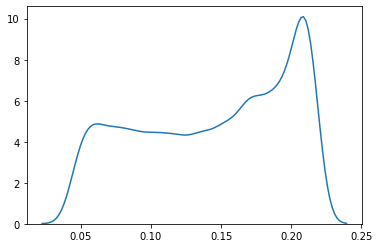

In [257]:
kdeplot(probability_arr[arr_sorted[sample][:,0], arr_sorted[sample][:,1]] )

In [ ]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[167715    183]
[58706    48]
[304621     84]
[294819     93]
[186117     16]
[3169   36]
[232161    131]
[138937    131]
[193822    136]
[76360   175]
[161414    237]
[200949    224]
[191349    138]
[196738     11]
[160897    103]
[265533    138]
[187644    125]
[261681     36]
[311642     90]
[171196     36]
[287951    118]
[67699   236]
[40066   120]
[257879    199]
[207722    149]
[194148     11]
[264431     16]
[226247    164]
[120129    125]
[90541     9]
[314222     83]
[20272   158]
[102571     22]
[332576    126]
[186078     72]
[136703    159]
[80206    72]
[189938    180]
[201826     16]
[220962     35]
[205719    131]
[191337    140]
[261249     11]
[324025     71]
[57829   126]
[238644    202]
[261266    131]
[190757     35]
[62776   176]
[1127   35]
[2527  128]
[312003    179]
[112847    235]
[51411    76]
[228091     13]
[239211    183]
[315207    150]
[77924    36]
[149283    236]
[2962   29]
[91842   192]
[57466   237]
[94056   101]
[225733     16]
[246102    123]
[224

[250720    125]
[312092    166]
[334564     38]
[135816     93]
[248608     84]
[67873   157]
[250476    136]
[69401   222]
[78630   183]
[93834   128]
[265424     79]
[88813   160]
[117620     72]
[61882    16]
[90471    91]
[149678    128]
[189083    146]
[277909     16]
[118583     86]
[171452    131]
[137011    155]
[66185   154]
[175721     16]
[256221    133]
[104137    128]
[8090   13]
[224914     89]
[75620    27]
[67430   178]
[300862    192]
[195885     36]
[228529    194]
[106303    112]
[35165    84]
[291700    239]
[238759    123]
[190628    128]
[289165     89]
[38223    79]
[234931    178]
[254847    158]
[243232     36]
[270993    178]
[134073     80]
[217966     86]
[114417    138]
[67379   167]
[42418    46]
[229566    218]
[264287    133]
[51812   170]
[328106     91]
[290628    128]
[135201    138]
[120973     98]
[12658    53]
[44640   123]
[180971     36]
[261139    131]
[68558   176]
[149367     79]
[219309     53]
[189904     79]
[307489     40]
[94697     9]
[2

[199798    196]
[90661   130]
[9039  128]
[100882    128]
[255819    128]
[147746     36]
[308739     16]
[17099   150]
[310890    138]
[67507   196]
[75264   180]
[194581     72]
[59530     9]
[228120    154]
[315281    105]
[196547     89]
[276404     11]
[247610    178]
[147589    142]
[66714   199]
[279914    105]
[215262    179]
[93991    53]
[20598   131]
[81213   192]
[243010     91]
[27939    90]
[120203    128]
[259861     41]
[63611   222]
[120977     38]
[50440   224]
[4893  204]
[4764  236]
[67448    20]
[313605    123]
[269897     48]
[136671     53]
[142953     76]
[238628    160]
[283533    161]
[16763   131]
[196164    128]
[224751     79]
[169257     36]
[80988   160]
[169322     13]
[191165     11]
[321212    176]
[48595    14]
[65196   183]
[245518    160]
[311236     89]
[308485    133]
[221200    180]
[152200    164]
[295835    146]
[4503   29]
[175753    214]
[194340    149]
[239326    204]
[260316    189]
[153296     93]
[281998    164]
[114360     31]
[71342   1

[198438    109]
[85038    18]
[206142     98]
[224285    204]
[280438     82]
[136773    105]
[317236     71]
[241270    224]
[236374     11]
[51402   105]
[60057   183]
[223253    131]
[70953    16]
[188816    224]
[102088     86]
[307565     36]
[176520    204]
[124759    126]
[16053    69]
[289504     16]
[52735   123]
[333710     57]
[211901     94]
[250794     73]
[2163   36]
[112601    105]
[63417   148]
[48027   171]
[230868    150]
[65246    27]
[196541    164]
[225079    123]
[186735    180]
[248126    159]
[166926    154]
[326732    128]
[306102    125]
[282971     17]
[22432    90]
[277453     82]
[205008    179]
[261808    171]
[305461     57]
[10094   105]
[268753     53]
[413 176]
[91809    53]
[183415    164]
[63875   166]
[52832   149]
[63585    75]
[173037    218]
[130245     11]
[32159    73]
[232682     16]
[1367  123]
[224028     35]
[17384    98]
[76699    11]
[286767     72]
[253050    175]
[119440     29]
[78653   126]
[287987     72]
[204193     79]
[312150    1

[78287   218]
[63871   133]
[175173    180]
[212656     36]
[219938     31]
[294405    183]
[228929    136]
[96103   155]
[111034    222]
[277389     16]
[260031    224]
[161468    222]
[141211     22]
[12047   101]
[146525    224]
[176270    157]
[79084    10]
[335013     29]
[51478    86]
[18195    35]
[328263     93]
[82796   178]
[115982     72]
[218873    159]
[98945   222]
[262115     11]
[126776    160]
[282954    204]
[195701    118]
[330338     76]
[314178      0]
[220650    103]
[195805    136]
[277937    205]
[112756    180]
[81888   150]
[216090    126]
[190641    154]
[66028   172]
[178511     31]
[72326   131]
[94099    57]
[60493    16]
[126700     41]
[20374   125]
[246661    138]
[279375    237]
[295173     36]
[118581     76]
[259048    131]
[201840    118]
[147622     89]
[309334    173]
[215099     18]
[3306  133]
[267579    180]
[252935    131]
[104859     89]
[109906    180]
[69905    31]
[174128    175]
[280720     79]
[191462     15]
[234091    133]
[142783    1

[138487     18]
[40938    41]
[14794   179]
[261570    178]
[188574    128]
[84114   130]
[7510  178]
[270393     89]
[228484    123]
[328880    222]
[178858     38]
[141746     53]
[265490    123]
[66950    89]
[251591    149]
[196479    138]
[288447    222]
[90161   138]
[242019    164]
[322375    204]
[256483     11]
[299007    154]
[41236   166]
[68031   155]
[66437   192]
[111376     31]
[200971    131]
[301992     29]
[217751    171]
[328707    160]
[72587   181]
[35864    84]
[171354    164]
[20009   123]
[304919    123]
[154329     38]
[124189     22]
[264623    138]
[3216   11]
[92976    84]
[229076    157]
[74278    79]
[161574     35]
[167465    214]
[207868    199]
[320360     11]
[15126   130]
[169315    218]
[72663    36]
[70670    79]
[281346    131]
[43303    71]
[289535    138]
[202421     11]
[79648   224]
[284816     36]
[10425     9]
[128021     16]
[316361     55]
[67873    89]
[200284    138]
[148107     72]
[78620    48]
[39946   196]
[98829   118]
[85678   138]
